# - Importing libraries:

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, BatchNormalization, Flatten
from keras.callbacks import TensorBoard, EarlyStopping,ModelCheckpoint,CSVLogger
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import ResNet50
import keras.utils


# - Importing and exploring data:

In [3]:
train_dir = "../data/dataset/Training/"
test_dir = "../data/dataset/Testing/"
img_dim = 224
bs = 32

train_data = keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=143,
    image_size=(img_dim, img_dim),
    batch_size=bs,
    label_mode="int",
)

val_data = keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=143,
    image_size=(img_dim, img_dim),
    batch_size=bs,
    label_mode="int",
)
test_data=keras.utils.image_dataset_from_directory(
    test_dir,
    seed=50,
    image_size=(img_dim, img_dim),
    label_mode="int",
)


Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


In [4]:
class_names=train_data.class_names
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

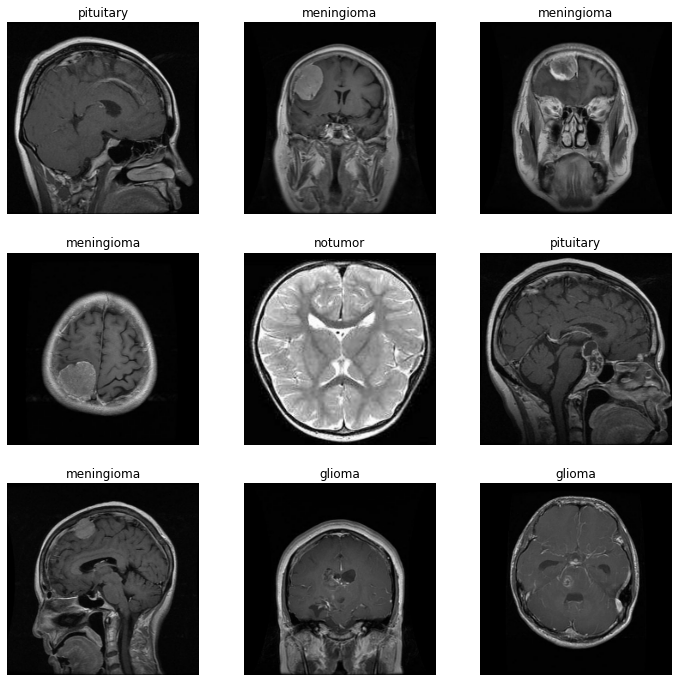

In [5]:
plt.figure(figsize=(12, 12))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# - Using pre-trained model (ResNet50):

In [36]:
resnet_model = Sequential()

pretrained_model = ResNet50(
    include_top=False,
    input_shape=(224,224, 3),
    pooling="avg",
    classes=4,
    weights="imagenet",
)


resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(4, activation='softmax'))

resnet_model.layers[0].trainable=False

In [37]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 24,638,852
Trainable params: 1,051,140
Non-trainable params: 23,587,712
_________________________________________________________________


In [38]:
opt =Adam(learning_rate=0.01)
resnet_model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

resnet_history = resnet_model.fit(train_data, validation_data=val_data, epochs=10)

Epoch 1/10
143/143 [==============================] - 539s 4s/step - loss: 1.5531 - accuracy: 0.8114 - val_loss: 0.3813 - val_accuracy: 0.8608
Epoch 2/10
143/143 [==============================] - 517s 4s/step - loss: 0.2551 - accuracy: 0.9046 - val_loss: 0.2497 - val_accuracy: 0.9054
Epoch 3/10
143/143 [==============================] - 526s 4s/step - loss: 0.2001 - accuracy: 0.9247 - val_loss: 0.2270 - val_accuracy: 0.9194
Epoch 4/10
143/143 [==============================] - 531s 4s/step - loss: 0.1544 - accuracy: 0.9403 - val_loss: 0.4020 - val_accuracy: 0.8835
Epoch 5/10
143/143 [==============================] - 536s 4s/step - loss: 0.1530 - accuracy: 0.9394 - val_loss: 0.3765 - val_accuracy: 0.8827
Epoch 6/10
143/143 [==============================] - 531s 4s/step - loss: 0.1278 - accuracy: 0.9530 - val_loss: 0.2555 - val_accuracy: 0.9194
Epoch 7/10
143/143 [==============================] - 538s 4s/step - loss: 0.1310 - accuracy: 0.9530 - val_loss: 0.2806 - val_accuracy: 0.9133

In [39]:
resnet_model.evaluate(test_data)

41/41 [==============================] - 125s 3s/step - loss: 0.1933 - accuracy: 0.9436


[0.19333717226982117, 0.9435545206069946]

# - Defining helper functions:

In [40]:
# plot accuracy and loss:
def plotRes(history):
    plt.figure(1, figsize = (15,8)) 
    
    plt.subplot(221)  
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('model accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'valid']) 
    
    plt.subplot(222)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'valid']) 

    plt.show()


#Predict tumor using MRI image
def predictMRI(img_path):
    image=cv2.imread(img_path)
    image_resized= cv2.resize(image, (img_dim,img_dim))
    image=np.expand_dims(image_resized,axis=0)

    pred=resnet_model.predict(image)
    output_class=class_names[np.argmax(pred)]
    print("The predicted class is", output_class)

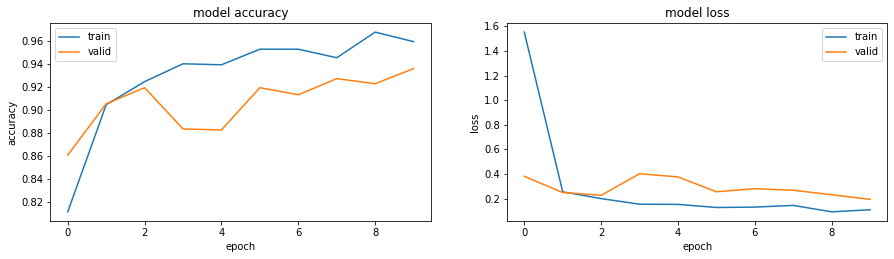

In [41]:
plotRes(resnet_history)

In [32]:
predictMRI("../data/Prediction check images/Prediction check images/glioma.jpg")

1/1 [==============================] - 0s 176ms/step
The predicted class is glioma


In [31]:
predictMRI("../data/Prediction check images/Prediction check images/meningioma.jpg")

1/1 [==============================] - 0s 215ms/step
The predicted class is meningioma


In [33]:
predictMRI("../data/Prediction check images/Prediction check images/no_tumor.jpg")

1/1 [==============================] - 0s 211ms/step
The predicted class is notumor


In [34]:
predictMRI("../data/Prediction check images/Prediction check images/pituitary.jpg")

1/1 [==============================] - 0s 182ms/step
The predicted class is pituitary


# - Earlystopping:

In [66]:
model = Sequential()

pretrained_model = ResNet50(
    include_top=False,
    input_shape=(224,224, 3),
    pooling="avg",
    classes=4,
    weights="imagenet",
)


model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.layers[0].trainable=False


In [67]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               1049088   
                                                                 
 dense_9 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 24,638,852
Trainable params: 1,051,140
Non-trainable params: 23,587,712
_________________________________________________________________


In [68]:
opt =Adam(learning_rate=0.01)
model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])


In [69]:
earlystop=EarlyStopping(patience=5)
filePath="model_class.h5"
checkpoint=ModelCheckpoint(filePath,monitor="val_accuracy",save_best_only=True,mode="max")
logFileName="model_log.csv"
csvLogger=CSVLogger(filename=logFileName,separator=",",append=False)
callbacksList=[checkpoint,csvLogger,earlystop]

In [70]:
history = model.fit(train_data, validation_data=val_data, epochs=10,callbacks=[callbacksList])

Epoch 1/10
143/143 [==============================] - 565s 4s/step - loss: 1.7549 - accuracy: 0.8147 - val_loss: 0.3266 - val_accuracy: 0.8888
Epoch 2/10
143/143 [==============================] - 570s 4s/step - loss: 0.2272 - accuracy: 0.9114 - val_loss: 0.3460 - val_accuracy: 0.8800
Epoch 3/10
143/143 [==============================] - 550s 4s/step - loss: 0.2098 - accuracy: 0.9199 - val_loss: 0.3423 - val_accuracy: 0.8818
Epoch 4/10
143/143 [==============================] - 543s 4s/step - loss: 0.1555 - accuracy: 0.9379 - val_loss: 0.2151 - val_accuracy: 0.9229
Epoch 5/10
143/143 [==============================] - 545s 4s/step - loss: 0.1398 - accuracy: 0.9488 - val_loss: 0.2981 - val_accuracy: 0.9072
Epoch 6/10
143/143 [==============================] - 541s 4s/step - loss: 0.1611 - accuracy: 0.9374 - val_loss: 0.3019 - val_accuracy: 0.8984
Epoch 7/10
143/143 [==============================] - 540s 4s/step - loss: 0.1139 - accuracy: 0.9569 - val_loss: 0.2603 - val_accuracy: 0.9212

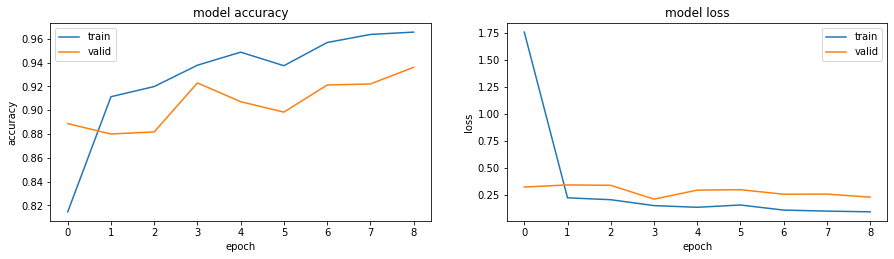

In [71]:
plotRes(history)

In [72]:
model_early=load_model("model_class.h5")
model_early.evaluate(test_data)

41/41 [==============================] - 126s 3s/step - loss: 0.2611 - accuracy: 0.9252


[0.2611113488674164, 0.9252479076385498]